In [37]:
# EM: added EDE to first part of nonlinear_pt. Python2 notebook, because I'm a hack

# import necessary modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft , rfft, irfft , fftfreq
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt
from classy import Class
from scipy.optimize import fsolve
from scipy.special import gamma
from scipy.special import hyp2f1
from scipy import interpolate
import sys
from time import time
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy import special
#from scipy.special import factorial
from scipy.misc import factorial # EM: use deprecated .misc version of factorial
import math

In [42]:
############################################
z_pk = 0.61
common_settings = {# fixed LambdaCDM parameters
                   'N_eff':3.046,
                   'A_s':2.089e-9,
                   'n_s':0.9649,
                   'tau_reio':0.052,
                   'omega_b':0.02237,
                   'omega_cdm':0.12,
    'h':0.72,
#                    'h':0.6736,
                   'YHe':0.2425,
                   # other output and precision parameters
                   'P_k_max_1/Mpc':100.0,
                   'z_pk':z_pk}  

EDE_common_settings = { #fixed EDE parameters
#          'fEDE': 0.122,
#          'log10z_c': 3.562,
         'f_scf':'3.98e+26',
         'm_scf':'5.31e-28',
         'thetai_scf': 2.83,
         #'h': .7219,
         '100*theta_s': 1.04152,
         'A_s': 2.215e-09,
         'n_s': 0.9889,
         'omega_b': 0.02253,
         'omega_cdm': 0.1306,
         'm_ncdm': 0.06, 
         'tau_reio': 0.072,
         'N_ncdm':1, 
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'z_pk':z_pk}

M = Class()
EDE= Class()

M.set(common_settings)
EDE.set(EDE_common_settings)
#let's first take a look at the one-loop power spectrum for matter without IR resummation
M.set({'output':'mPk',
       'non linear':'SPT',
       'IR resummation':'No',
       'Bias tracers':'Yes'
#        'RSD':'No',
#        'AP':'No',
#        'SigmaFOG':0.
      })

EDE.set({'output':'mPk',
       'non linear':'SPT',
       'IR resummation':'No',
       'Bias tracers':'Yes'
#         'RSD':'No',
#         'AP':'No',
#         'SigmaFOG':0.
        })

M.compute()

EDE.compute()
# EM: this takes an insanely long time!

In [43]:
#now we compute all the spectra including IR resummation, RSD, 
#and AP generated for a fiducial cosmology with $\Omega_m=0.31$ 
M1 = Class()
M1.set(common_settings)
M1.set({'output':'mPk',
        'non linear':'SPT',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31',
        'SigmaFOG':0.
       })
M1.compute()
EDE1 = Class()
EDE1.set(EDE_common_settings)
EDE1.set({'output':'mPk',
        'non linear':'SPT',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
          'SigmaFOG':0.,
        'Omfid':'0.31' #EM left Omegafid fixed to LCDM value 
       })
EDE1.compute()

In [44]:
# esthetic definitions for the plots
font = {'size'   : 10, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='small'
plt.rcParams["figure.figsize"] = [10.0,8.0]

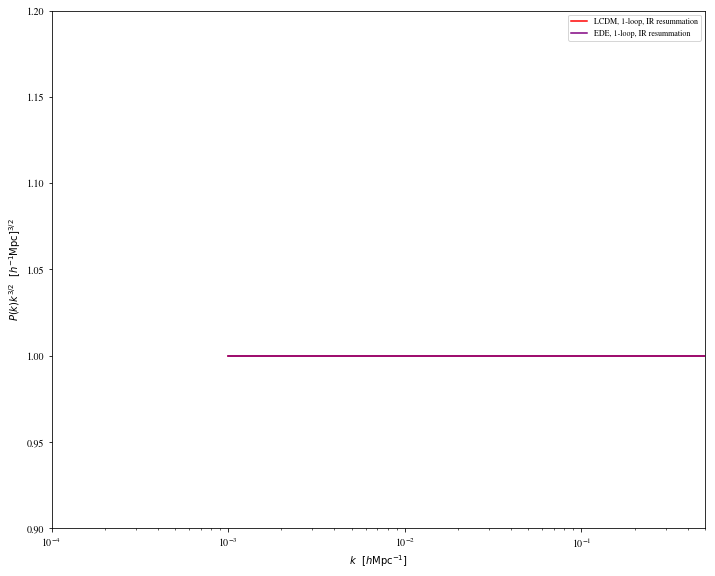

In [45]:
#############################################
#
# extract LCDM spectra 
#
#############################################

h = M.h()
kvec = np.logspace(-3,np.log10(3),1000) # array of kvec in h/Mpc
khvec = kvec*h # array of kvec in 1/Mpc

# Create figures
fig_Pkir, ax_Pkir = plt.subplots()

legarray = []
pk_lin = []
pk_full = []
pk_full_ir = []


cs = 0. # in units [Mpc/h]^2
for kh in khvec:
    # basic real space matter power spectrum without IR resummation below
    pk_full.append((M.pk(kh,z_pk)[0]+M.pk(kh,z_pk)[14]+M.pk(kh,z_pk)[16]*0+M.pk(kh,z_pk)[17]*0+2*cs*M.pk(kh,z_pk)[10]/h**2.)*h**3.)
    # linear theory matter power spectrum below
    pk_lin.append(M1.pk_lin(kh,z_pk)*h**3.)
    # real space matter power spectrum below 
    pk_full_ir.append((M1.pk(kh,z_pk)[0]+M1.pk(kh,z_pk)[14]+M1.pk(kh,z_pk)[16]*0+M1.pk(kh,z_pk)[17]*0+2*cs*M1.pk(kh,z_pk)[10]/h**2.)*h**3.)

h1 = EDE.h()
kvec1 = np.logspace(-3,np.log10(3),1000) # array of kvec in h/Mpc
khvec1 = kvec*h1 # array of kvec in 1/Mpc

pk_EDE_lin = []
pk_EDE_full = []
pk_EDE_full_ir = []

cs = 0. # in units [Mpc/h]^2
for kh1 in khvec1:
    # basic real space matter power spectrum without IR resummation below
    pk_EDE_full.append((EDE.pk(kh1,z_pk)[0]+EDE.pk(kh1,z_pk)[14]+0*EDE.pk(kh1,z_pk)[16]+0*EDE.pk(kh1,z_pk)[17]+2*cs*EDE.pk(kh1,z_pk)[10]/h1**2.)*h1**3.)
    # linear theory matter power spectrum below
    pk_EDE_lin.append(EDE1.pk_lin(kh1,z_pk)*h1**3.)
    # real space matter power spectrum below
    pk_EDE_full_ir.append((EDE1.pk(kh1,z_pk)[0]+EDE1.pk(kh1,z_pk)[14]+0*EDE1.pk(kh1,z_pk)[16]+0*EDE1.pk(kh1,z_pk)[17]+2*cs*EDE1.pk(kh1,z_pk)[10]/h1**2.)*h1**3.)


# ax_Pkir.plot(kvec,np.array(pk_lin)*kvec**1.5,color='purple',linestyle='-.',label='linear')
# ax_Pkir.plot(kvec,np.array(pk_full)*kvec**1.5,color='b',linestyle='--',label='1-loop, no IR resummation')
ax_Pkir.semilogx(kvec,np.array(pk_full_ir)/np.array(pk_full),color='r',linestyle='-',label='LCDM, 1-loop, IR resummation')

# ax_Pkir.plot(kvec1,np.array(pk_EDE_lin)*kvec1**1.5,color='darkgreen',linestyle='-.',label='linear')
# ax_Pkir.plot(kvec1,np.array(pk_EDE_full)*kvec1**1.5,color='darkorange',linestyle='--',label='1-loop, no IR resummation')
ax_Pkir.semilogx(kvec1,np.array(pk_EDE_full_ir)/np.array(pk_EDE_full),color='purple',linestyle='-',label='EDE, 1-loop, IR resummation')

ax_Pkir.set_xlim([1.e-4,0.5])
ax_Pkir.set_ylim([0.9,1.2])
ax_Pkir.set_xlabel(r'$k \,\,\,\, [h\mathrm{Mpc}^{-1}]$')
ax_Pkir.set_ylabel(r'$P(k)k^{3/2}\,\,\,\, [h^{-1}\mathrm{Mpc}]^{3/2}$')
ax_Pkir.legend(fontsize='8',ncol=1,loc='upper right')
fig_Pkir.savefig('real_Pk_IR.pdf')
fig_Pkir.tight_layout()    



In [11]:

#############################################
#
# EDE: extract spectra
#
#############################################



In [15]:
def J0(r,nu):
    return -1.*np.sin(pi*nu/2.)*r**(-3.-1.*nu)*special.gamma(2+nu)/(2.*pi**2.)
Nmax = 256
bk = -1.1001
kmax = 100.
k0 = 1.e-4
rtab = np.zeros(Nmax)
rmin = 0.01
rmax = 1000.
Delta = log(kmax/k0) / (Nmax - 1)
Delta_r = log(rmax/rmin) / (Nmax - 1)

Pdiscrin0 = np.zeros(Nmax);
Pdiscrin1 = np.zeros(Nmax);
Pdiscrin2 = np.zeros(Nmax);
jsNm = np.arange(-Nmax/2,Nmax/2+1,1)
etam = bk + 2*1j*pi*(jsNm)/Nmax/Delta
kbins3 = np.zeros(Nmax);

for i in range(Nmax):
    kbins3[i] = k0 * exp(Delta * i)
    kinloop1 = kbins3[i] * h
    rtab[i] = rmin * exp(Delta_r * i)
    theory0 = (EDE1.pk_lin(kinloop1,z_pk))*h**3.
    theory1 = (EDE.pk(kinloop1,z_pk)[0]+EDE.pk(kinloop1,z_pk)[14]+2*cs*EDE.pk(kinloop1,z_pk)[10]/h**2.)*h**3.
    theory2 = (EDE1.pk(kinloop1,z_pk)[0]+EDE1.pk(kinloop1,z_pk)[14]+2*cs*EDE1.pk(kinloop1,z_pk)[10]/h**2.)*h**3.
    Pdiscrin0[i] = theory0 * exp( -1.*(kinloop1/4.)**4. -1.*bk*i*Delta)
    Pdiscrin1[i] = theory1 * exp( -1.*(kinloop1/4.)**4. -1.*bk*i*Delta)
    Pdiscrin2[i] = theory2 * exp( -1.*(kinloop1/4.)**4. -1.*bk*i*Delta)

cm0 = np.fft.fft(Pdiscrin0)/ Nmax
cm1 = np.fft.fft(Pdiscrin1)/ Nmax
cm2 = np.fft.fft(Pdiscrin2)/ Nmax
cmsym0 = np.zeros(Nmax+1,dtype=np.complex_)
cmsym1 = np.zeros(Nmax+1,dtype=np.complex_)
cmsym2 = np.zeros(Nmax+1,dtype=np.complex_)

for i in range(Nmax+1):
    if (i+2 - Nmax/2) < 1:
        cmsym0[i] =  k0**(-etam[i])*np.conjugate(cm0[-i + Nmax/2])
        cmsym1[i] =  k0**(-etam[i])*np.conjugate(cm1[-i + Nmax/2])
        cmsym2[i] =  k0**(-etam[i])*np.conjugate(cm2[-i + Nmax/2])
    else:
        cmsym0[i] = k0**(-etam[i])* cm0[i - Nmax/2]
        cmsym1[i] = k0**(-etam[i])* cm1[i - Nmax/2]
        cmsym2[i] = k0**(-etam[i])* cm2[i - Nmax/2]
        
cmsym0[-1] = cmsym0[-1] / 2
cmsym0[0] = cmsym0[0] / 2
cmsym1[-1] = cmsym1[-1] / 2
cmsym1[0] = cmsym1[0] / 2
cmsym2[-1] = cmsym2[-1] / 2
cmsym2[0] = cmsym2[0] / 2

xi0 = np.zeros(Nmax)
xi1 = np.zeros(Nmax)
xi2 = np.zeros(Nmax)

for i in range(Nmax):
    for j in range(Nmax + 1):
        xi0[i] = xi0[i] + np.real(cmsym0[j]*J0(rtab[i],etam[j]))
        xi1[i] = xi1[i] + np.real(cmsym1[j]*J0(rtab[i],etam[j]))
        xi2[i] = xi2[i] + np.real(cmsym2[j]*J0(rtab[i],etam[j]))

xi0inter = interpolate.InterpolatedUnivariateSpline(rtab,xi0)
xi1inter = interpolate.InterpolatedUnivariateSpline(rtab,xi1)
xi2inter = interpolate.InterpolatedUnivariateSpline(rtab,xi2)

rvec = np.logspace(0.,np.log10(3),1000) # array of rvec in Mpc/h
rvec = 10**rvec
# xi_lin = np.zeros(len(rvec))
# xi_loop = np.zeros(len(rvec))
# xi_loopir = np.zeros(len(rvec))
# for i in range(len(rvec)):
#     xi_lin[i]=xi0inter(rvec[i])*rvec[i]
#     xi_loop[i]=xi1inter(rvec[i])*rvec[i]
#     xi_loopir[i]=xi2inter(rvec[i])*rvec[i]
    
xi_lin = []
xi_loop =[]
xi_loopir =[]
for r in rvec:
    xi_lin.append(xi0inter(r)*r)
    xi_loop.append(xi1inter(r)*r)
    xi_loopir.append(xi2inter(r)*r)

fig_xi, ax_xi = plt.subplots()
ax_xi.plot(rvec,xi_lin,color='purple',linestyle='-.',label='linear')
ax_xi.plot(rvec,xi_loop,color='b',linestyle='--',label='1-loop, no IR resummation')
ax_xi.plot(rvec,xi_loopir,color='red',linestyle='-',label='1-loop, IR resummation')
ax_xi.set_xlim([60.,140.])
ax_xi.set_ylim([-0.03,0.15])
ax_xi.set_xlabel(r'$r \,\,\,\, [h^{-1}\mathrm{Mpc}]$')
ax_xi.set_ylabel(r'$r\cdot \xi(r)\,\,\,\, [h^{-1}\mathrm{Mpc}]$')
ax_xi.legend(fontsize='16',ncol=1,loc='upper left')
fig_xi.tight_layout()
fig_xi.savefig('real_Xi.pdf')